<a href="https://colab.research.google.com/github/somnathsingh31/multi-tasking_muti-label-classification/blob/main/Fashion_product_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from datasets import load_dataset

ds = load_dataset("ashraq/fashion-product-images-small")

README.md:   0%|          | 0.00/867 [00:00<?, ?B/s]

(…)-00000-of-00002-6cff4c59f91661c3.parquet:   0%|          | 0.00/136M [00:00<?, ?B/s]

(…)-00001-of-00002-bb459e5ac5f01e71.parquet:   0%|          | 0.00/135M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
        num_rows: 44072
    })
})

In [6]:
ds['train'][0]

{'id': 15970,
 'gender': 'Men',
 'masterCategory': 'Apparel',
 'subCategory': 'Topwear',
 'articleType': 'Shirts',
 'baseColour': 'Navy Blue',
 'season': 'Fall',
 'year': 2011.0,
 'usage': 'Casual',
 'productDisplayName': 'Turtle Check Men Navy Blue Shirt',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>}

In [7]:
import os

os.mkdir('images')
#download data

for data in ds["train"]:
    img = data["image"]
    img_id = data["id"]
    img_path = os.path.join("images", f"{img_id}.jpg")
    img.save(img_path)

In [8]:
def prepare_dataset(all_data):
    labels = []
    for data in all_data:
        label = {k:v for k,v in data.items() if k not in ['year', 'productDisplayName', 'image']}
        labels.append(label)

    df = pd.DataFrame(labels)
    df['img_path'] = 'images/' + df['id'].astype(str) + '.jpg'

    df = df.drop('id', axis=1)

    return df

In [9]:
data = prepare_dataset(ds['train'])

In [10]:
data.head()

,gender,masterCategory,subCategory,articleType,baseColour,season,usage,img_path
0,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,Casual,images/15970.jpg
1,Men,Apparel,Bottomwear,Jeans,Blue,Summer,Casual,images/39386.jpg
2,Women,Accessories,Watches,Watches,Silver,Winter,Casual,images/59263.jpg
3,Men,Apparel,Bottomwear,Track Pants,Black,Fall,Casual,images/21379.jpg
4,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual,images/53759.jpg


In [11]:
label_columns = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']
label_map = {}

for col in label_columns:
    classes = sorted(data[col].unique())
    label_map[col] = {cls: idx for idx, cls in enumerate(classes)}
    data[col + '_idx'] = data[col].map(label_map[col])

label_columns_updated = ['gender_idx','masterCategory_idx','subCategory_idx','articleType_idx','baseColour_idx','season_idx','usage_idx']

In [12]:
data.head()

,gender,masterCategory,subCategory,articleType,baseColour,season,usage,img_path,gender_idx,masterCategory_idx,subCategory_idx,articleType_idx,baseColour_idx,season_idx,usage_idx
0,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,Casual,images/15970.jpg,2,1,38,103,25,0,0
1,Men,Apparel,Bottomwear,Jeans,Blue,Summer,Casual,images/39386.jpg,2,1,6,56,2,2,0
2,Women,Accessories,Watches,Watches,Silver,Winter,Casual,images/59263.jpg,4,0,42,138,37,3,0
3,Men,Apparel,Bottomwear,Track Pants,Black,Fall,Casual,images/21379.jpg,2,1,6,126,1,0,0
4,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual,images/53759.jpg,2,1,38,132,13,2,0


In [13]:
def train_test_split(df):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    n = len(df)
    n_train = int(n * 0.80)
    n_val = int(n * 0.15)
    n_test = n - n_train - n_val

    train_df = df.iloc[:n_train].reset_index(drop=True)
    val_df = df.iloc[n_train:n_train + n_val].reset_index(drop=True)
    test_df = df.iloc[n_train + n_val:].reset_index(drop=True)

    return train_df, val_df, test_df

In [14]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class FashionDataset(Dataset):
    def __init__(self, df, label_columns, is_train=True):
        self.df = df.reset_index(drop=True)
        self.label_columns = label_columns

        if is_train:
            self.transform=transforms.Compose([
                transforms.Resize((224,224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])
        else:
            self.transform=transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['img_path']).convert('RGB')
        image = self.transform(image)

        labels = {
            f"label_{col.replace('_idx','')}": torch.tensor(row[col], dtype=torch.long)
            for col in self.label_columns
        }

        return image, labels

In [15]:
train_df, val_df, test_df = train_test_split(data)

In [16]:
train_dataset = FashionDataset(df=train_df, label_columns=label_columns_updated, is_train=True)
test_dataset = FashionDataset(df=test_df, label_columns=label_columns_updated, is_train=False)
val_dataset = FashionDataset(df=val_df, label_columns=label_columns_updated, is_train=False)

In [17]:
print(f"Length of train dataset: {len(train_dataset)}\n\nLength of test dataset: {len(test_dataset)}\n\nLength of validation dataset: {len(val_dataset)}")

Length of train dataset: 35257

Length of test dataset: 2205

Length of validation dataset: 6610


In [18]:
import torch.nn as nn
from torchvision import models

class MultiTaskResNet50(nn.Module):
    def __init__(self, n_gender, n_masterCategory, n_subCategory, n_articleType, n_baseColour, n_season, n_usage):
        super().__init__()

        # Load pretrained model
        resnet = models.resnet50(weights='IMAGENET1K_V1')

        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer

        feature_dim = resnet.fc.in_features

        # Output head for each task
        self.gender_head = nn.Linear(feature_dim, n_gender)
        self.masterCategory_head = nn.Linear(feature_dim, n_masterCategory)
        self.subCategory_head = nn.Linear(feature_dim + n_masterCategory, n_subCategory)
        self.articleType_head = nn.Linear(feature_dim + n_subCategory, n_articleType)
        self.baseColour_head = nn.Linear(feature_dim, n_baseColour)
        self.season_head = nn.Linear(feature_dim, n_season)
        self.usage_head = nn.Linear(feature_dim, n_usage)

    def forward(self, x):
        batch_size = x.size(0)
        # Feature extraction from ResNet
        feats = self.backbone(x)              # [B, 2048, 1, 1]
        feats = feats.view(batch_size, -1)    # [B, 2048]

        # Parallel heads
        out_gender = self.gender_head(feats)
        out_masterCategory = self.masterCategory_head(feats)
        out_baseColour = self.baseColour_head(feats)
        out_season = self.season_head(feats)
        out_usage = self.usage_head(feats)

        # Hierarchical heads
        masterCategory_probs = torch.softmax(out_masterCategory, dim=1)  # [B, n_masterCategory]
        feats_subCategory = torch.cat([feats, masterCategory_probs], dim=1)
        out_subCategory = self.subCategory_head(feats_subCategory)

        subCategory_probs = torch.softmax(out_subCategory, dim=1)
        feats_articleType = torch.cat([feats, subCategory_probs], dim=1)
        out_articleType = self.articleType_head(feats_articleType)

        return {
            'gender': out_gender,
            'masterCategory': out_masterCategory,
            'subCategory': out_subCategory,
            'articleType': out_articleType,
            'baseColour': out_baseColour,
            'season': out_season,
            'usage': out_usage,
        }

In [19]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, loss_fn, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device

    def train(self, epochs):
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            for batch_x, labels in self.train_loader:
                batch_x = batch_x.to(self.device)
                labels = {k: v.to(self.device) for k,v in labels.items()}

                self.optimizer.zero_grad()

                outputs = self.model(batch_x)

                loss = (
                    self.loss_fn(outputs['gender'], labels['label_gender'])
                    + self.loss_fn(outputs['masterCategory'], labels['label_masterCategory'])
                    + self.loss_fn(outputs['subCategory'], labels['label_subCategory'])
                    + self.loss_fn(outputs['articleType'], labels['label_articleType'])
                    + self.loss_fn(outputs['baseColour'], labels['label_baseColour'])
                    + self.loss_fn(outputs['season'], labels['label_season'])
                    + self.loss_fn(outputs['usage'], labels['label_usage'])
                )

                loss.backward()

                self.optimizer.step()

                running_loss += loss.item() * batch_x.size(0)
            epoch_loss = running_loss / len(self.train_loader.dataset)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

    def evaluate(self):
        self.model.eval()
        correct = {
            'gender': 0, 'masterCategory': 0, 'subCategory': 0,
            'articleType': 0, 'baseColour': 0, 'season': 0, 'usage': 0
        }
        total = 0

        with torch.no_grad():
            for batch_x, labels in self.val_loader:
                batch_x = batch_x.to(self.device)
                labels = {k: v.to(self.device) for k, v in labels.items()}
                outputs = self.model(batch_x)
                batch_size = batch_x.size(0)
                total += batch_size

                for task in outputs.keys():
                    preds = outputs[task].argmax(dim=1)
                    correct[task] += (preds == labels[f"label_{task}"]).sum().item()

        # Print accuracy for each task
        for task in correct:
            acc = correct[task] / total
            print(f"{task} accuracy: {acc:.4f}")

        return {task: correct[task] / total for task in correct}

    def predict(self, x):
        self.model.eval()
        x = x.to(self.device)

        with torch.no_grad():
            outputs = self.model(x)
            preds = {}
            for task, out in outputs.items():
                preds[task] = out.argmax(dim=1)  # Returns tensor of predicted class indices
        return preds


In [20]:
from torch.utils.data import DataLoader
import torch.optim as optim

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes_per_task = {}
for label, classes in label_map.items():
    num_classes_per_task[f"n_{label}"] = len(classes)


model = MultiTaskResNet50(
    n_gender = num_classes_per_task["n_gender"],
    n_masterCategory = num_classes_per_task["n_masterCategory"],
    n_subCategory = num_classes_per_task["n_subCategory"],
    n_articleType = num_classes_per_task["n_articleType"],
    n_baseColour = num_classes_per_task["n_baseColour"],
    n_season = num_classes_per_task["n_season"],
    n_usage = num_classes_per_task["n_usage"]
)

model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

trainer = Trainer(model, train_dataloader, val_dataloader, loss_fn, optimizer, device)

trainer.train(15)

trainer.evaluate()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


Epoch 1/15 - Loss: 5.3725
Epoch 2/15 - Loss: 3.8085
Epoch 3/15 - Loss: 3.3930
Epoch 4/15 - Loss: 3.1031
Epoch 5/15 - Loss: 2.9153
Epoch 6/15 - Loss: 2.7423
Epoch 7/15 - Loss: 2.6045
Epoch 8/15 - Loss: 2.4470
Epoch 9/15 - Loss: 2.3305
Epoch 10/15 - Loss: 2.1942
Epoch 11/15 - Loss: 2.0774
Epoch 12/15 - Loss: 1.9589
Epoch 13/15 - Loss: 1.8338
Epoch 14/15 - Loss: 1.7071
Epoch 15/15 - Loss: 1.5703
gender accuracy: 0.9089
masterCategory accuracy: 0.9879
subCategory accuracy: 0.9575
articleType accuracy: 0.8481
baseColour accuracy: 0.6399
season accuracy: 0.7676
usage accuracy: 0.9047


{'gender': 0.9089258698940998,
 'masterCategory': 0.9878971255673222,
 'subCategory': 0.9574886535552194,
 'articleType': 0.8481089258698941,
 'baseColour': 0.6399394856278366,
 'season': 0.7676248108925869,
 'usage': 0.9046898638426626}

In [21]:
torch.save(trainer.model.state_dict(), "final_model.pth")

In [22]:
from google.colab import files
files.download("final_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
import random
n_samples = 20
random_indices = random.sample(range(len(test_dataset)), n_samples)

In [24]:
images = []
labels_list = []
for idx in random_indices:
    image, labels = test_dataset[idx]
    images.append(image.unsqueeze(0))  # Add batch dimension
    labels_list.append(labels)

import torch
batch_images = torch.cat(images, dim=0)  # Shape: [20, 3, 224, 224]

In [25]:
preds = trainer.predict(batch_images)

In [26]:
for i in range(n_samples):
    print(f"\nImage {i+1}:")
    for task in preds:
        pred = preds[task][i].item()  # Predicted class index
        true = labels_list[i][f'label_{task}'].item()
        print(f"  {task}: predicted={pred}, true={true}")


Image 1:
  gender: predicted=2, true=2
  masterCategory: predicted=1, true=1
  subCategory: predicted=38, true=38
  articleType: predicted=132, true=132
  baseColour: predicted=32, true=32
  season: predicted=0, true=0
  usage: predicted=0, true=0

Image 2:
  gender: predicted=4, true=4
  masterCategory: predicted=1, true=1
  subCategory: predicted=38, true=38
  articleType: predicted=125, true=125
  baseColour: predicted=31, true=31
  season: predicted=2, true=2
  usage: predicted=0, true=0

Image 3:
  gender: predicted=2, true=2
  masterCategory: predicted=1, true=1
  subCategory: predicted=38, true=38
  articleType: predicted=103, true=103
  baseColour: predicted=2, true=44
  season: predicted=0, true=0
  usage: predicted=2, true=2

Image 4:
  gender: predicted=2, true=4
  masterCategory: predicted=0, true=0
  subCategory: predicted=42, true=42
  articleType: predicted=138, true=138
  baseColour: predicted=44, true=44
  season: predicted=3, true=3
  usage: predicted=0, true=0

Imag

In [27]:
reverse_label_map = {}
for label, class_to_idx in label_map.items():
    idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
    reverse_label_map[label] = idx_to_class

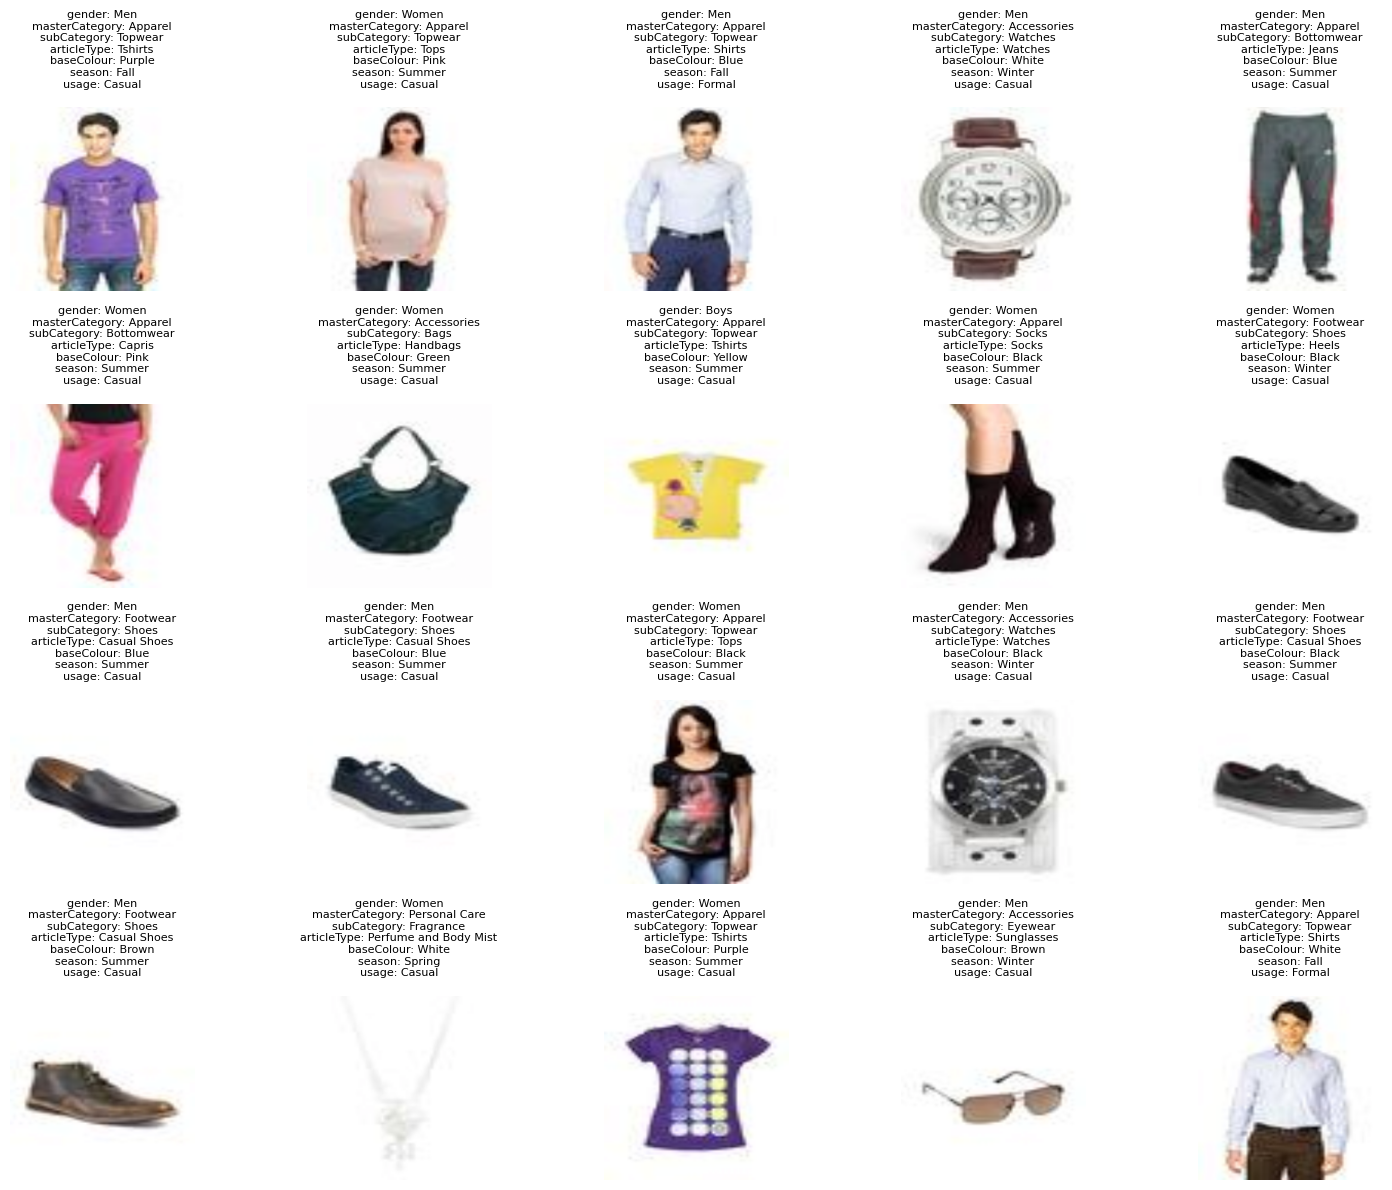

In [31]:
num_cols = 5
num_rows = (n_samples + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols*3, num_rows*3))

for i in range(n_samples):
    img = images[i].cpu()
    if img.dim() == 4:
        img = img.squeeze(0)
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.permute(1, 2, 0).numpy().clip(0, 1)

    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(img)
    plt.axis('off')

    title_str = ""
    for task in preds:
        pred_idx = preds[task][i].item()
        pred_name = reverse_label_map[task][pred_idx]
        title_str += f"{task}: {pred_name}\n"
    plt.title(title_str, fontsize=8)

plt.tight_layout()
plt.show()